# 1. Import Library dan Persiapan Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer
from sklearn.model_selection import train_test_split as split
from tensorflow.keras.preprocessing import image_dataset_from_directory as load_ds

/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# menggabungkan semua gambar dari 2 folder ke satu
src_dirs = ['dataset/seg_train/seg_train', 'dataset/seg_test/seg_test']
combined_dir = 'dataset/combined'

if os.path.exists(combined_dir):
 try: shutil.rmtree(combined_dir)
 except: pass

for s in src_dirs:
 for c in os.listdir(s):
  p = os.path.join(s,c)
  if not os.path.isdir(p): continue
  d = os.path.join(combined_dir,c)
  os.makedirs(d,exist_ok=True)
  for f in os.listdir(p):
   if f.lower().endswith('.jpg'):
    try: shutil.copy(os.path.join(p,f), os.path.join(d,f))
    except: pass

# cek jumlah gambar per kelas
print("\njumlah gambar per kelas:")
for cl in sorted(os.listdir(combined_dir)):
 p = os.path.join(combined_dir,cl)
 if os.path.isdir(p):
  n = len([f for f in os.listdir(p) if f.lower().endswith('.jpg')])
  print(cl,":",n)

# split ke train, val, test
split_dir = 'dataset/split'

if os.path.exists(split_dir):
 try: shutil.rmtree(split_dir)
 except: pass

for bagian in ['train','val','test']:
 for cl in os.listdir(combined_dir):
  os.makedirs(os.path.join(split_dir, bagian, cl), exist_ok=True)

for cl in os.listdir(combined_dir):
  p = os.path.join(combined_dir,cl)
  if not os.path.isdir(p): continue
  files = [f for f in os.listdir(p) if f.lower().endswith('.jpg')]
  if len(files)<3:
   print("lewati",cl)
   continue
  tr,tmp = split(files,test_size=0.3,random_state=1)
  vl,ts = split(tmp,test_size=0.5,random_state=1)
  for folder,names in [('train',tr),('val',vl),('test',ts)]:
   dest = os.path.join(split_dir,folder,cl)
   for nm in names:
    try: shutil.copy(os.path.join(p,nm), os.path.join(dest,nm))
    except: pass

# load data dari folder split
train_ds = load_ds(os.path.join(split_dir,'train'),
 image_size=(224,224),batch_size=32,label_mode='categorical')
val_ds   = load_ds(os.path.join(split_dir,'val'),
 image_size=(224,224),batch_size=32,label_mode='categorical')
test_ds  = load_ds(os.path.join(split_dir,'test'),
 image_size=(224,224),batch_size=32,shuffle=False,label_mode='categorical')

# ambil label kelas
class_names = train_ds.class_names
print("kelas yg dimuat:",class_names)


jumlah gambar per kelas:
buildings : 2628
forest : 2745
glacier : 2957
mountain : 3037
sea : 2784
street : 2883
Found 11920 files belonging to 6 classes.
Found 2556 files belonging to 6 classes.
Found 2558 files belonging to 6 classes.
kelas yg dimuat: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# 2. Preprocessing Data

In [3]:
# normalisasi pixel [0,1]
norm = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map( lambda x,y: (norm(x),y ))
val_ds=val_ds.map(lambda x,y:(norm(x),y))
test_ds = test_ds.map(lambda x, y: (norm(x),y))

# 3. Membangun Model Transfer Learning (MobileNetV2 + Conv2D)

In [4]:
# load base model, imagenet
base_model = MobileNetV2( (224,224,3), include_top=False, weights='imagenet' )
base_model.trainable = False  

# model utama 
model = Sequential([
 base_model,
 Conv2D(32, 3, activation='relu', padding='same'),
 MaxPooling2D(2),
 GlobalAveragePooling2D(),
 Dropout(.5),
 Dense(128, activation='relu'),
 Dense(6,activation='softmax')
])

In [5]:
model.compile(optimizer='adam',
 loss='categorical_crossentropy' ,
    metrics= [ 'accuracy' ])

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,654 (10.04 MB)

 Trainable params: 373,670 (1.43 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 4. Training, Callback, Plot

In [7]:
early_stop=EarlyStopping(monitor='val_loss',
      patience=5,restore_best_weights = True )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
      factor=.2,patience=3,min_lr=1e-6 )

In [8]:
history=model.fit(train_ds,
    validation_data = val_ds,
    epochs = 25 ,
    callbacks=[early_stop,reduce_lr] )

Epoch 1/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 123s 327ms/step - accuracy: 0.6478 - loss: 0.8610 - val_accuracy: 0.8858 - val_loss: 0.3391 - learning_rate: 0.0010
Epoch 2/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 135s 361ms/step - accuracy: 0.8090 - loss: 0.4854 - val_accuracy: 0.8924 - val_loss: 0.3207 - learning_rate: 0.0010
Epoch 3/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 152s 407ms/step - accuracy: 0.8271 - loss: 0.4386 - val_accuracy: 0.9030 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 4/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 194s 521ms/step - accuracy: 0.8418 - loss: 0.3984 - val_accuracy: 0.9014 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 5/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 178s 478ms/step - accuracy: 0.8533 - loss: 0.3706 - val_accuracy: 0.9041 - val_loss: 0.2821 - learning_rate: 0.0010
Epoch 6/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 173s 464ms/step - accuracy: 0.8657 - loss: 0.3464 - val_accuracy: 0.9014 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 7/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 174s 466ms/step - accura

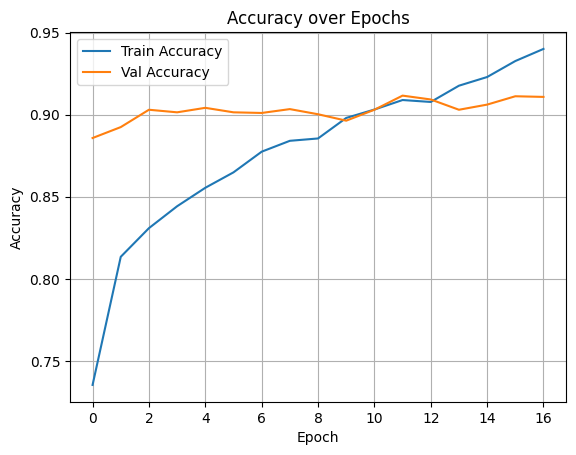

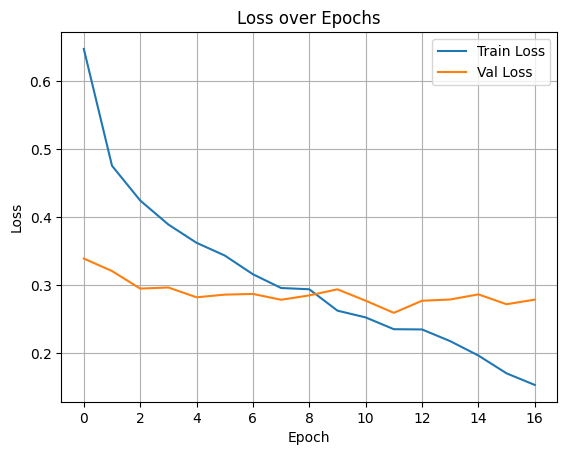

In [9]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 34s 422ms/step - accuracy: 0.9018 - loss: 0.2575
Test Accuracy: 91.01%


# 5. Ekspor Model

In [11]:
model.export('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  5825103472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5799266784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5799264848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5824115280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5824117568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4526974752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  4383264432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5825151568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5824497968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5824496208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5824163680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

### TF-LITE

In [12]:
# simpan model ke tflite
saved_model_path = 'saved_model'
tflite_output_path = 'tflite/model.tflite'
label_output_path = 'tflite/label.txt'

try:
 os.makedirs(os.path.dirname(tflite_output_path), exist_ok=True)
except: pass

conv = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = conv.convert()

# tulis ke file
with open(tflite_output_path,'wb') as f: f.write(tflite_model)

print("tflite model disimpan:",tflite_output_path)

try:
 class_names
except:
 class_names = ['buildings','forest','glacier','mountain','sea','street']
 print("class_names gak ada, pake list default")

# tulis label 
with open(label_output_path,'w') as f:
 for lbl in class_names: f.write(lbl+'\n')

print("label disimpan ke",label_output_path)

tflite model disimpan: tflite/model.tflite
label disimpan ke tflite/label.txt


W0000 00:00:1745068094.386871 7043146 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745068094.387071 7043146 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745068094.444543 7043146 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


### TFJS

In [13]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

Defaulting to user installation because normal site-packages is not writeable
/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1745068103.259432 7086561 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1745068103.259542 7086561 single_machine.cc:374] Starting new session


# 6. Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


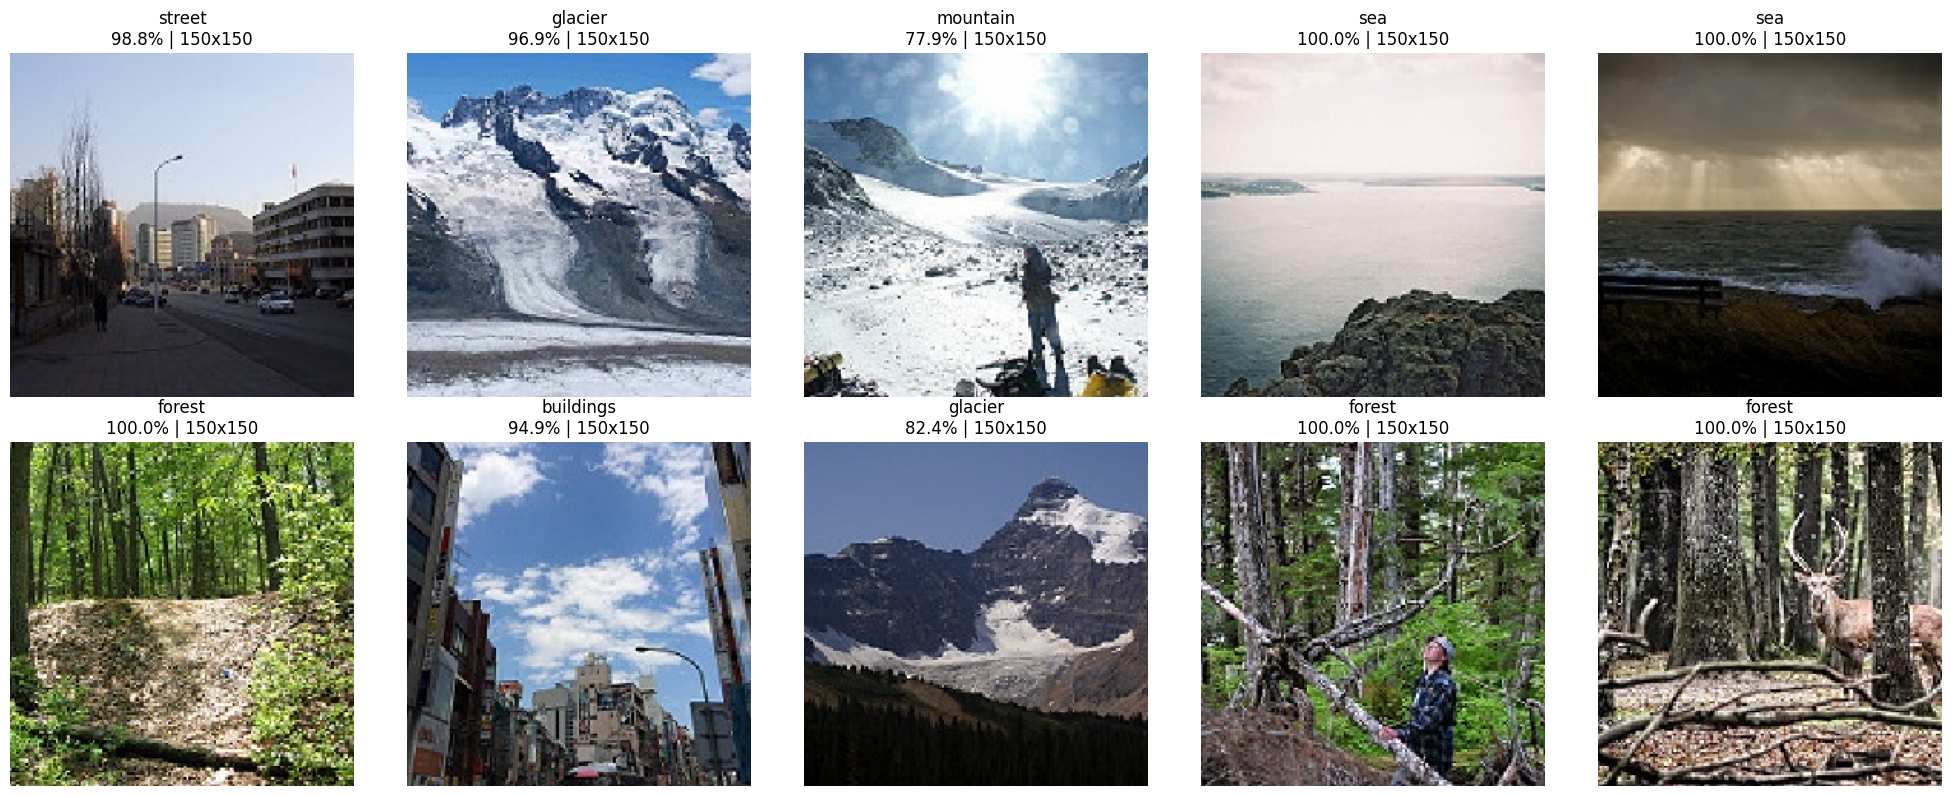

In [19]:
# ambil 10 gambar random dari folder prediksi
img_folder = 'dataset/seg_pred/seg_pred/'
imgs = [os.path.join(img_folder,f) for f in os.listdir(img_folder) if f.endswith('.jpg')]
pilih = random.sample(imgs, 10)

plt.figure(figsize=(20,8))

for i,p in enumerate(pilih):
  ori = image.load_img(p)
  im = image.load_img(p, target_size=(224,224))
  arr = image.img_to_array(im)/255.
  arr = np.expand_dims(arr,0)

  pred = model.predict(arr)
  label = class_names[np.argmax(pred)]
  conf = np.max(pred)*100
  size = ori.size

  plt.subplot(2,5,i+1)
  plt.imshow(im)
  plt.axis('off')
  plt.title(f"{label}\n{conf:.1f}% | {size[0]}x{size[1]}")

plt.tight_layout()
plt.show()

### Inferencing menggunakan SavedModel

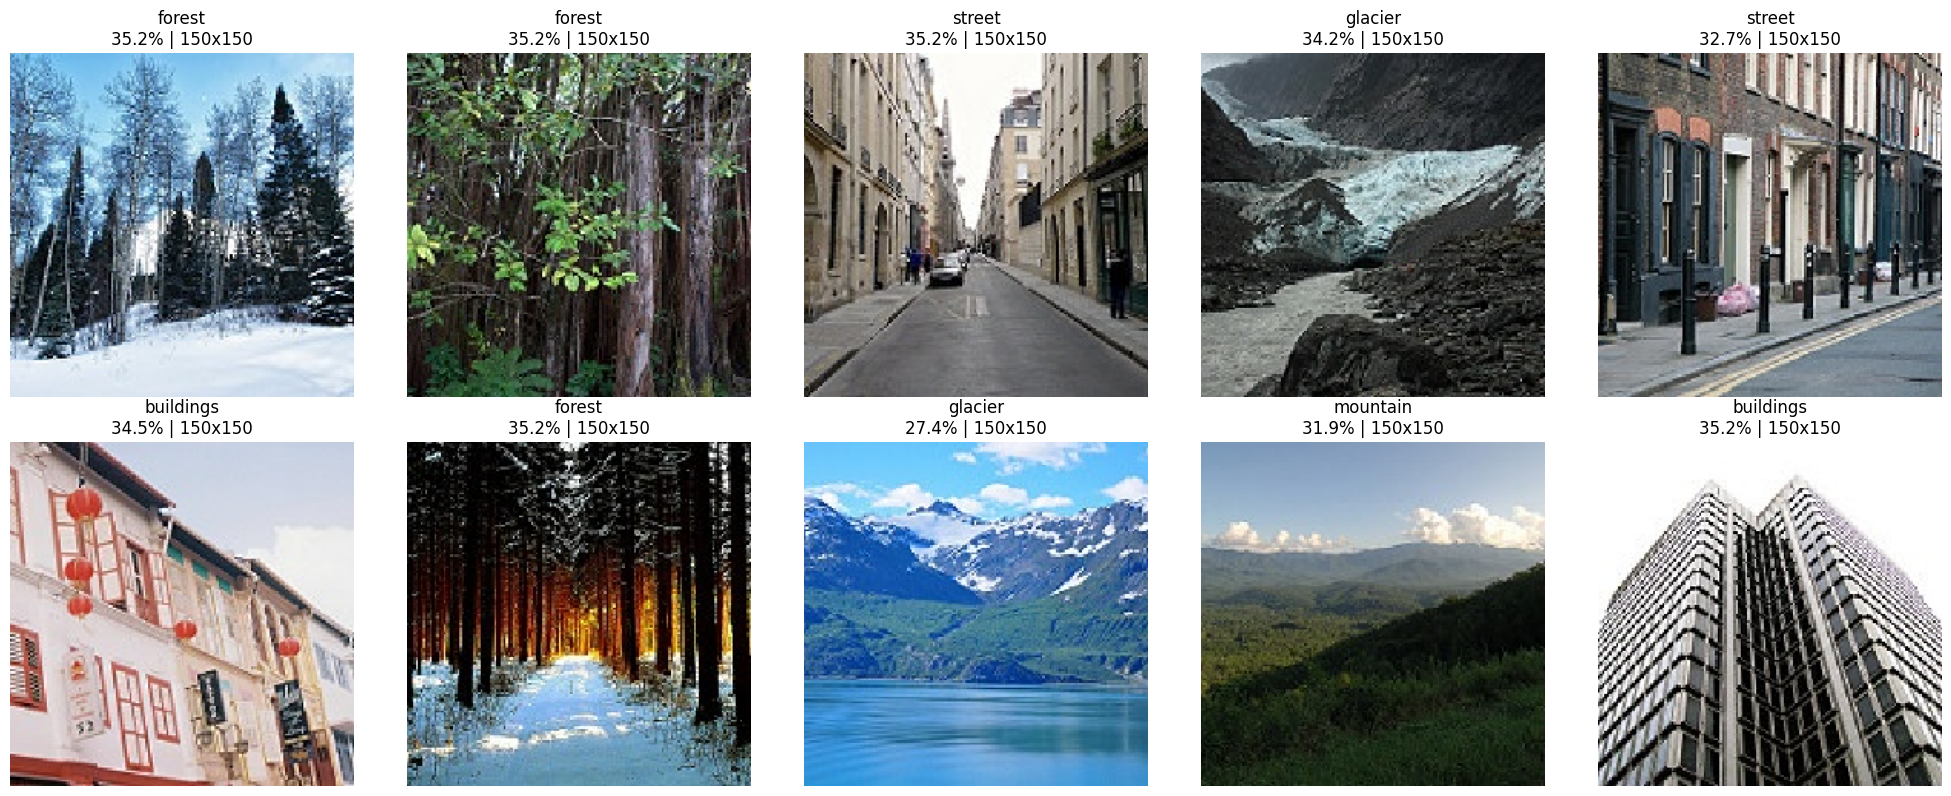


[1] 17071.jpg
prediksi: forest
confidence:
 buildings : 12.96%
 forest    : 35.19%
 glacier   : 12.97%
 mountain  : 12.96%
 sea       : 12.96%
 street    : 12.96%

[2] 9424.jpg
prediksi: forest
confidence:
 buildings : 12.96%
 forest    : 35.22%
 glacier   : 12.96%
 mountain  : 12.96%
 sea       : 12.96%
 street    : 12.96%

[3] 19423.jpg
prediksi: street
confidence:
 buildings : 12.99%
 forest    : 12.96%
 glacier   : 12.96%
 mountain  : 12.96%
 sea       : 12.96%
 street    : 35.17%

[4] 19275.jpg
prediksi: glacier
confidence:
 buildings : 13.06%
 forest    : 13.06%
 glacier   : 34.19%
 mountain  : 13.55%
 sea       : 13.07%
 street    : 13.06%

[5] 23074.jpg
prediksi: street
confidence:
 buildings : 14.49%
 forest    : 13.20%
 glacier   : 13.20%
 mountain  : 13.20%
 sea       : 13.20%
 street    : 32.69%

[6] 7995.jpg
prediksi: buildings
confidence:
 buildings : 34.50%
 forest    : 13.03%
 glacier   : 13.03%
 mountain  : 13.03%
 sea       : 13.03%
 street    : 13.38%

[7] 14066.jpg

In [20]:
# load model keras 3 dari saved_model
path = 'saved_model'
reload = TFSMLayer(path,call_endpoint='serving_default')

# fungsi prediksi 1 gambar
def pred(imgarr):
 out = reload(imgarr)
 return tf.nn.softmax(out['output_0']).numpy()

# ambil 10 gambar random dari folder pred
img_folder = 'dataset/seg_pred/seg_pred/'
files = [os.path.join(img_folder,f) for f in os.listdir(img_folder) if f.endswith('.jpg')]
sampel = random.sample(files,10)

plt.figure(figsize=(20,8))

for i,p in enumerate(sampel):
 asli = image.load_img(p)
 im = image.load_img(p,target_size=(224,224))
 arr = image.img_to_array(im)/255.
 arr = np.expand_dims(arr,0)

 out = pred(arr)
 label = class_names[np.argmax(out)]
 conf = np.max(out)*100
 size = asli.size

 plt.subplot(2,5,i+1)
 plt.imshow(im)
 plt.axis('off')
 plt.title(f"{label}\n{conf:.1f}% | {size[0]}x{size[1]}")

plt.tight_layout()
plt.show()

# print detail confidence tiap gambar
for i,p in enumerate(sampel):
 im = image.load_img(p,target_size=(224,224))
 arr = image.img_to_array(im)/255.
 arr = np.expand_dims(arr,0)

 out = pred(arr)
 label = class_names[np.argmax(out)]

 print(f'\n[{i+1}] {os.path.basename(p)}')
 print("prediksi:",label)
 print("confidence:")
 for j,l in enumerate(class_names):
  print(f" {l:<10}: {out[0][j]*100:.2f}%")